# Homework 2 | Exploring Options | Tasks 1-4 due 09/22/25 | Task 5 due 09/24/25

Now that you have all of the options data stored locally on your computer and in pkl files, we can begin working with it. Your task will be to edit the monthly data and make some observations about its structure. See below.

## Tasks

### 1. For each file, remove the following columns: ['ImpliedVolatility', 'Delta','Gamma', 'Vega', 'Theta']

### 2. Add a column for the SPX index. MAKE SURE THE DATES MATCH! Hint: You might want to set the index of the options data to the date column... If yFinance doesn't let you download the SPX data skip this for now.

### 2. On paper or using markdown, use your knowledge of calculus to compute explicit formulas for the Greeks we discussed

### 3. Add columns of the Greeks using your formulae

### 4. Using the Newton Raphson method discussed on 9/17/25, calculate implied volatilies for each option and add this as a column to the data

### 5. Now plot the following and keep an eye out for specific relationships. We will talk about what we notice.

### 5.1 Using the ATM Strike and fixed date, plot the following:
* Call delta vs. time to maturity
* Call gamma vs. time to maturity
* Call theta vs. time to maturity
* Call vega vs. time to maturity
* Call implied volatility vs. time to maturity

Do the same for puts. What do you notice about the greeks for calls and puts?

### 5.2 From the span of 2015-2020:
* Calculate a 5,21,63,129 rolling realiezd volatilities for SPX
* Plot the implied volatilties for ATM options expiring at roughly the same 5,21,63,129 date marks. What I mean by this is, iterate through the data and calculate the implied volatility for ATM calls expriing in those times for every single day. You won't be using the same option for the 5 years if you get what I mean... Maybe it's clear already, and I'm being dramatic.
* Make some plots of IV - RV. What do you notice? When does the graph become positive?

### 5.3 Pick a date and maturity of your own choice and plot the following:
* Strike vs. delta
* Strike vs. theta
* Strike vs. IV
* Strike vs. option price

Feel free to do any additional analysis with the data at any time by the way. We are getting familiar with how options work here!

## Your work starts here

In [2]:
import numpy as np
import yfinance as yf
import os
import pandas as pd

SPX = yf.Ticker("^GSPC")
df_SPX = SPX.history(period="30y", interval="1d")
df_SPX.index = df_SPX.index.tz_localize(None)
close_series = df_SPX['Close'].round(3)

folder = r"C:\TAMID\OptionsData"

drop_cols = ['ImpliedVolatility', 'Delta','Gamma', 'Vega', 'Theta']

for file in os.listdir(folder):
    if file.endswith(".pkl"):
        file_path = os.path.join(folder, file)

        df = pd.read_pickle(file_path)
        header_str = df.columns[0]
        new_columns = header_str.split('\t')

        df = df.iloc[:,0].str.split("\t", expand=True)
        df.columns = new_columns
        df["Date"] = pd.to_datetime(df["Date"].astype(str), format = "%Y%m%d")
        #print(df.head())
        df = df.drop(drop_cols, axis=1, errors='ignore')
        df.set_index("Date", inplace=True)
        df["SPX"] = close_series.reindex(df.index)

        df.to_pickle(file_path)

In [ ]:
    import numpy as np
from scipy.stats import norm
from scipy.optimize import newton, brentq
import pandas as pd
import os

r= 0.04
sigma = 0.2 # Vol Guess

folder = r"C:\TAMID\OptionsData"

def d1_d2(S, K, T, r, sigma):
    sigma = np.clip(sigma, 1e-8, 5.0)
    T = np.maximum(T, 1e-8)
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return d1, d2

def black_scholes_price(S, K, T, r, sigma, option_type='C') :
    d1, d2 = d1_d2(S, K, T, r, sigma)
    if option_type == "C":
        return (S * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    else:
        return (K * np.exp(-r * T) * norm.cdf(-d2)) - (S * norm.cdf(-d1))
#-----------------GREEKS-----------------
def delta(S, K, T, r, sigma, option_type = 'C'):
    d1, _ = d1_d2(S, K, T, r, sigma)
    if option_type == 'C':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def gamma(S, K, T, r, sigma):
    d1, _ = d1_d2(S, K, T, r, sigma)
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def theta(S, K, T, r, sigma, option_type = 'C'):
    d1, d2 = d1_d2(S, K, T, r, sigma)

    first = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))

    if option_type == 'C':
        return first - r * K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return first + r * K * np.exp(-r * T) * norm.cdf(-d2)

def vega(S, K, T, r, sigma):
    d1, _ = d1_d2(S, K, T, r, sigma)
    return S * norm.pdf(d1) * np.sqrt(T)

def inflexion_point(S, K, T, r) :
    m = S / (K * np.exp(-r * T))
    return np.sqrt(2 * abs(np.log(m) / T))

#-----------------ImpliedVol-----------------
# def implied_vol(S, K, T, r, market_price, option_type = "C", tol=0.05, max_iter = 10000):
#     T = max(T, 1e-8)
#     sigma = 0.3
#
#     for i in range(max_iter):
#         price = black_scholes_price(S, K, T, r, sigma, option_type)
#         v = vega(S, K, T, r, sigma)
#         diff = price - market_price  # f(sigma)
#         if abs(diff) < tol:
#             return sigma
#
#         if v <= 1e-8 or np.isnan(v):
#             continue
#
#         sigma -= diff / v
#
#         if sigma <= 0:
#             sigma = 1e-4
#         elif sigma > 5:
#             sigma = 5.0
#
#     return np.nan


def implied_vol_newton(S, K, T, r, market_price, option_type = 'C', sigma_init = 0.2, tol = 1e-8, maxiter = 100, max_step = 0.5, sigma_min = 1e-8, sigma_max = 5.0):

    try:
        S = float(S); K = float(K); T = float(T); market_price = float(market_price)
    except Exception:
        return -99.99

    if not np.isfinite(S) or not np.isfinite(K) or not np.isfinite(T) or not np.isfinite(market_price):
        return -99.99

    # No-arbitrage bounds
    discK = K * np.exp(-r * T)
    if option_type.upper().startswith('C'):
        lower = max(0.0, S - discK)
        upper = S
    else:
        lower = max(0.0, discK - S)
        upper = discK
    if (market_price < lower - 1e-12) or (market_price > upper + 1e-12):
        return -99.99
    if np.isclose(market_price, lower, atol=1e-12) or np.isclose(market_price, upper, atol=1e-12):
        return sigma_min

    def f(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price

    def fprime(sigma):
        v = vega(S, K, T, r, sigma)
        if not np.isfinite(v) or v == 0.0:
            raise RuntimeError("invalid vega")
        return v

    x0 = float(np.clip(sigma_init, sigma_min, sigma_max))

    try:
        iv = newton(f, x0=x0, fprime=fprime, tol=tol, maxiter=maxiter)
        if not np.isfinite(iv) or iv < sigma_min or iv > sigma_max:
            raise RuntimeError("sigma out of bounds")
        return iv
    except Exception:
        # Fallback to a bracket method
        try:
            iv = brentq(f, sigma_min, sigma_max)
            return iv
        except Exception:
            print(f"No IV for S={S}, K={K}, T={T}, price={market_price}, type={option_type}")
            return -99.99


for file_i, file in enumerate(os.listdir(folder), start = 1):
    if not file.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, file)
    print(f"\n=== [{file_i}] Processing file: {file} ===")
    df = pd.read_pickle(file_path)
    print(f"Loaded {len(df):,} rows")

    df["SPX"] = pd.to_numeric(df["SPX"], errors="coerce")
    df["Strike"] = pd.to_numeric(df["Strike"], errors="coerce")
    df["BestBid"] = pd.to_numeric(df["BestBid"], errors="coerce")
    df["BestOffer"] = pd.to_numeric(df["BestOffer"], errors="coerce")

    #-----------------HELPERS------------------------
    df["Expiration"] = pd.to_datetime(df["Expiration"], format="%Y%m%d")
    df["T"] = (df["Expiration"] - df.index).dt.days / 365
    df["T"] = df["T"].clip(lower=1e-8)
    df["DaysToExpiration"] = df["T"] * 365
    df["Mid"] = (df["BestBid"] + df["BestOffer"]) / 2

    #df["InflexionPoint"] = inflexion_point(df["SPX"], df["Strike"], df["T"], r)

    #df["ImpliedVolatility"] = df.apply(lambda row: implied_vol_newton(row["SPX"], row["Strike"], row["T"], r, row["Mid"], row["CallPut"]), axis = 1)

    S_arr     = df["SPX"].values
    K_arr     = df["Strike"].values
    T_arr     = df["T"].values
    Mid_arr   = df["Mid"].values
    Type_arr  = df["CallPut"].values

    print("Calculating implied volatilities...")
    implied_vols = [
        implied_vol_newton(S, K, T, r, Mid, opt_type)
        for S, K, T, Mid, opt_type in zip(S_arr, K_arr, T_arr, Mid_arr, Type_arr)
        ]
    df["ImpliedVolatility"] = implied_vols

    print("Computing Greeks...")
    for cp in ["C", "P"]:
        mask = df["CallPut"] == cp
        S = df.loc[mask, "SPX"]
        K = df.loc[mask, "Strike"]
        T = df.loc[mask, "T"]
        sigma = df.loc[mask, "ImpliedVolatility"]

        bad_mask = (sigma == -99.99)

        df.loc[mask, "BlackScholes"] = np.where(bad_mask, -99.99, black_scholes_price(S, K, T, r, sigma, cp))
        df.loc[mask, "Delta"] = np.where(bad_mask, -99.99, delta(S, K, T, r, sigma, cp))
        df.loc[mask, "Theta"] = np.where(bad_mask, -99.99, theta(S, K, T, r, sigma, cp))

    S = df["SPX"]
    K = df["Strike"]
    T = df["T"]
    sigma = df["ImpliedVolatility"]
    bad_mask = (sigma == -99.99)

    df["Gamma"] = np.where(bad_mask, -99.99, gamma(S, K, T, r, sigma))
    df["Vega"] = np.where(bad_mask, -99.99, vega(S, K, T, r, sigma))

    pd.set_option("display.max_rows", None)     # None = no limit
    pd.set_option("display.max_columns", None)

    df.to_pickle(file_path)
    print(f"Finished file: {file}\n")


=== [1] Processing file: IVYOPPRCD_199601.pkl ===
Loaded 5,580 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199601.pkl


=== [2] Processing file: IVYOPPRCD_199602.pkl ===
Loaded 6,159 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199602.pkl


=== [3] Processing file: IVYOPPRCD_199603.pkl ===
Loaded 6,526 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199603.pkl


=== [4] Processing file: IVYOPPRCD_199604.pkl ===
Loaded 6,016 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199604.pkl


=== [5] Processing file: IVYOPPRCD_199605.pkl ===
Loaded 6,516 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199605.pkl


=== [6] Processing file: IVYOPPRCD_199606.pkl ===
Loaded 5,908 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199606.pkl


=== [7] Processing file: IV

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_199706.pkl


=== [19] Processing file: IVYOPPRCD_199707.pkl ===
Loaded 10,824 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199707.pkl


=== [20] Processing file: IVYOPPRCD_199708.pkl ===
Loaded 10,398 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199708.pkl


=== [21] Processing file: IVYOPPRCD_199709.pkl ===
Loaded 10,056 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199709.pkl


=== [22] Processing file: IVYOPPRCD_199710.pkl ===
Loaded 10,452 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199710.pkl


=== [23] Processing file: IVYOPPRCD_199711.pkl ===
Loaded 8,806 rows
Calculating implied volatilities...
No IV for S=958.98, K=400.0, T=0.005479452054794521, price=560.125, type=C
Computing Greeks...
Finished file: IVYOPPRCD_199711.pkl


=== [24] Processing file: IVYOPPRCD_199712.pkl =

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_199802.pkl


=== [27] Processing file: IVYOPPRCD_199803.pkl ===
Loaded 10,856 rows
Calculating implied volatilities...
No IV for S=1089.74, K=400.0, T=0.005479452054794521, price=690.125, type=C
Computing Greeks...
Finished file: IVYOPPRCD_199803.pkl


=== [28] Processing file: IVYOPPRCD_199804.pkl ===
Loaded 10,687 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199804.pkl


=== [29] Processing file: IVYOPPRCD_199805.pkl ===
Loaded 9,694 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199805.pkl


=== [30] Processing file: IVYOPPRCD_199806.pkl ===
Loaded 10,605 rows
Calculating implied volatilities...
No IV for S=1107.11, K=400.0, T=0.00821917808219178, price=710.125, type=C
Computing Greeks...
Finished file: IVYOPPRCD_199806.pkl


=== [31] Processing file: IVYOPPRCD_199807.pkl ===
Loaded 10,632 rows
Calculating implied volatilities...
No IV for S=1186.75, K=400.0, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1179.98, K=400.0, T=0.005479452054794521, price=781.75, type=C
Computing Greeks...
Finished file: IVYOPPRCD_199812.pkl


=== [37] Processing file: IVYOPPRCD_199901.pkl ===
Loaded 8,654 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199901.pkl


=== [38] Processing file: IVYOPPRCD_199902.pkl ===
Loaded 9,135 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1224.03, K=400.0, T=0.00821917808219178, price=825.5, type=C
Computing Greeks...
Finished file: IVYOPPRCD_199902.pkl


=== [39] Processing file: IVYOPPRCD_199903.pkl ===
Loaded 10,758 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_199903.pkl


=== [40] Processing file: IVYOPPRCD_199904.pkl ===
Loaded 10,111 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199904.pkl


=== [41] Processing file: IVYOPPRCD_199905.pkl ===
Loaded 9,934 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199905.pkl


=== [42] Processing file: IVYOPPRCD_199906.pkl ===
Loaded 10,720 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199906.pkl


=== [43] Processing file: IVYOPPRCD_199907.pkl ===
Loaded 11,285 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199907.pkl


=== [44] Processing file: IVYOPPRCD_199908.pkl ===
Loaded 12,450 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_199908.pkl


=== [45] Processing file: IVYOPPRCD_199909.pkl ===
Loaded 11,136 rows
Calculating implied volatilities...
No IV for S=1318.

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200001.pkl


=== [50] Processing file: IVYOPPRCD_200002.pkl ===
Loaded 10,406 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200002.pkl


=== [51] Processing file: IVYOPPRCD_200003.pkl ===
Loaded 11,468 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200003.pkl


=== [52] Processing file: IVYOPPRCD_200004.pkl ===
Loaded 9,748 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200004.pkl


=== [53] Processing file: IVYOPPRCD_200005.pkl ===
Loaded 10,956 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200005.pkl


=== [54] Processing file: IVYOPPRCD_200006.pkl ===
Loaded 10,168 rows
Calculating implied volatilities...
No IV for S=1470.54, K=500.0, T=0.00821917808219178, price=974.125, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200006.pkl


=== [55] Processing file: IVYOPPRCD_200007.pkl =

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1312.15, K=900.0, T=0.0027397260273972603, price=424.375, type=C
No IV for S=1312.15, K=850.0, T=0.0027397260273972603, price=475.375, type=C
No IV for S=1312.15, K=800.0, T=0.0027397260273972603, price=525.375, type=C
No IV for S=1312.15, K=750.0, T=0.0027397260273972603, price=575.375, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200012.pkl


=== [61] Processing file: IVYOPPRCD_200101.pkl ===
Loaded 10,863 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200101.pkl


=== [62] Processing file: IVYOPPRCD_200102.pkl ===
Loaded 9,508 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200102.pkl


=== [63] Processing file: IVYOPPRCD_200103.pkl ===
Loaded 10,897 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200103.pkl


=== [64] Processing file: IVYOPPRCD_200104.pkl ===
Loaded 10,072 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200104.pkl


=== [65] Processing file: IVYOPPRCD_200105.pkl ===
Loaded 11,152 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200105.pkl


=== [66] Processing file: IVYOPPRCD_200106.pkl ===
Loaded 9,621 rows
Calculating implied volatilities...
No IV for S=1214.36, K=1160.0, T=0.0027397260273972603, price=993.5, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200106.pkl


=== [67] Processing file: IVYOPPRCD_200107.pkl ===
Loaded 9,560 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200107.pkl


=== [68] Processing file: IVYOPPRCD_200108.pkl ===
Loaded 10,494 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200108.pkl


=== [69] Processing file: IVYOPPRCD_200109.pkl =

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200109.pkl


=== [70] Processing file: IVYOPPRCD_200110.pkl ===
Loaded 12,984 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200110.pkl


=== [71] Processing file: IVYOPPRCD_200111.pkl ===
Loaded 11,526 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200111.pkl


=== [72] Processing file: IVYOPPRCD_200112.pkl ===
Loaded 10,174 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200112.pkl


=== [73] Processing file: IVYOPPRCD_200201.pkl ===
Loaded 9,829 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200201.pkl


=== [74] Processing file: IVYOPPRCD_200202.pkl ===
Loaded 9,192 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200202.pkl


=== [75] Processing file: IVYOPPRCD_200203.pkl ===
Loaded 9,650 rows
Calculating implied volatilities...
Computing Greeks...

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200208.pkl


=== [81] Processing file: IVYOPPRCD_200209.pkl ===
Loaded 11,400 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200209.pkl


=== [82] Processing file: IVYOPPRCD_200210.pkl ===
Loaded 13,218 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200210.pkl


=== [83] Processing file: IVYOPPRCD_200211.pkl ===
Loaded 11,456 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200211.pkl


=== [84] Processing file: IVYOPPRCD_200212.pkl ===
Loaded 11,408 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200212.pkl


=== [85] Processing file: IVYOPPRCD_200301.pkl ===
Loaded 10,702 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=901.78, K=625.0, T=0.0027397260273972603, price=292.2, type=C
No IV for S=901.78, K=650.0, T=0.0027397260273972603, price=267.2, type=C
No IV for S=901.78, K=675.0, T=0.0027397260273972603, price=242.2, type=C
No IV for S=901.78, K=600.0, T=0.0027397260273972603, price=317.2, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200301.pkl


=== [86] Processing file: IVYOPPRCD_200302.pkl ===
Loaded 9,976 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200302.pkl


=== [87] Processing file: IVYOPPRCD_200303.pkl ===
Loaded 10,816 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200303.pkl


=== [88] Processing file: IVYOPPRCD_200304.pkl ===
Loaded 10,420 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200304.pkl


=== [89] Processing file: IVYOPPRCD_200305.pkl ===
Loaded 10,642 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200305.pkl


=== [90] Processing file: IVYOPPRCD_200306.pkl ===
Loaded 10,727 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200306.pkl


=== [91] Processing file: IVYOPPRCD_200307.pkl ===
Loaded 10,902 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200307.pkl


=== [92] Processing file: IVYOPPRCD_200308.pkl ===
Loaded 10,820 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200308.pkl


=== [93] Processing file: IVYOPPRCD_200309.pkl ===
Loaded 11,303 rows
Calculating implied volatilities...
No IV for S=1036.3, K=500.0, T=0.0027397260273972603, price=993.5, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200309.pkl


=== [94] Processing file: IVYOPPRCD_200310.pkl ===
Loaded 12,222 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200310.pkl


=== [95] Processing file: IVYOPPRCD_200311.pkl =

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200402.pkl


=== [99] Processing file: IVYOPPRCD_200403.pkl ===
Loaded 12,133 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1122.32, K=500.0, T=0.005479452054794521, price=623.9, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200403.pkl


=== [100] Processing file: IVYOPPRCD_200404.pkl ===
Loaded 11,082 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200404.pkl


=== [101] Processing file: IVYOPPRCD_200405.pkl ===
Loaded 10,922 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200405.pkl


=== [102] Processing file: IVYOPPRCD_200406.pkl ===
Loaded 11,639 rows
Calculating implied volatilities...
No IV for S=1132.05, K=400.0, T=0.005479452054794521, price=0.5, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200406.pkl


=== [103] Processing file: IVYOPPRCD_200407.pkl ===
Loaded 12,000 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200407.pkl


=== [104] Processing file: IVYOPPRCD_200408.pkl ===
Loaded 12,718 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200408.pkl


=== [105] Processing file: IVYOPPRCD_200409.pkl ===
Loaded 11,738 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200409.pkl


=== [106] Processing file: IVYOPPRCD_200410.pkl ===
Loaded 11,700 rows
Calculating implied volatilities...
No IV for S=1108.2, K=500.0, T=0.0027397260273972603, price=0.25, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200410.pkl


=== [107] Processing file: IVYOPPRCD_200411.pkl ===
Loaded 11,686 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200411.pkl


=== [108] Processing file: IVYOPPRCD_200412.pkl ===
Loaded 12,236 rows
Calculating implied volatilities...
No IV for S=1203.21, K=500.0, T=0.005479452054794521, price=704.2, type=C
No IV for S=1203.21, K=400.0

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200412.pkl


=== [109] Processing file: IVYOPPRCD_200501.pkl ===
Loaded 11,424 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200501.pkl


=== [110] Processing file: IVYOPPRCD_200502.pkl ===
Loaded 10,518 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200502.pkl


=== [111] Processing file: IVYOPPRCD_200503.pkl ===
Loaded 12,280 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200503.pkl


=== [112] Processing file: IVYOPPRCD_200504.pkl ===
Loaded 12,173 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200504.pkl


=== [113] Processing file: IVYOPPRCD_200505.pkl ===
Loaded 12,780 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200505.pkl


=== [114] Processing file: IVYOPPRCD_200506.pkl ===
Loaded 12,880 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200506.pkl


=== [115] Processing file: IVYOPPRCD_200507.pkl ===
Loaded 11,422 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200507.pkl


=== [116] Processing file: IVYOPPRCD_200508.pkl ===
Loaded 13,517 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200508.pkl


=== [117] Processing file: IVYOPPRCD_200509.pkl ===
Loaded 12,506 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200509.pkl


=== [118] Processing file: IVYOPPRCD_200510.pkl ===
Loaded 13,302 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200510.pkl


=== [119] Processing file: IVYOPPRCD_200511.pkl ===
Loaded 13,385 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200511.pkl


=== [120] Processing file: IVYOPPRCD_200512.pkl ===
Loaded 13,327 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200512.pkl


=== [121] Processing file: IVYOPPRCD_200601.pkl ===
Loaded 12,733 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200601.pkl


=== [122] Processing file: IVYOPPRCD_200602.pkl ===
Loaded 12,153 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200602.pkl


=== [123] Processing file: IVYOPPRCD_200603.pkl ===
Loaded 14,787 rows
Calculating implied volatilities...
No IV for 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200606.pkl


=== [127] Processing file: IVYOPPRCD_200607.pkl ===
Loaded 13,718 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200607.pkl


=== [128] Processing file: IVYOPPRCD_200608.pkl ===
Loaded 14,982 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200608.pkl


=== [129] Processing file: IVYOPPRCD_200609.pkl ===
Loaded 13,316 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1316.28, K=500.0, T=0.005479452054794521, price=818.0, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200609.pkl


=== [130] Processing file: IVYOPPRCD_200610.pkl ===
Loaded 15,487 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200610.pkl


=== [131] Processing file: IVYOPPRCD_200611.pkl ===
Loaded 15,184 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200611.pkl


=== [132] Processing file: IVYOPPRCD_200612.pkl ===
Loaded 15,050 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200612.pkl


=== [133] Processing file: IVYOPPRCD_200701.pkl ===
Loaded 14,718 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200701.pkl


=== [134] Processing file: IVYOPPRCD_200702.pkl ===
Loaded 14,744 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200702.pkl


=== [135] Processing file: IVYOPPRCD_200703.pkl ===
Loaded 18,358 rows
Calculating implied volatilities...
No IV for S=1387.17, K=500.0, T=0.00821917808219178, price=889.35, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200703.pkl


=== [136] Processing file: IVYOPPRCD_200704.pkl ===
Loaded 16,684 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200704.pkl


=== [137] Processing file: IVYOPPRCD_200705

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200711.pkl


=== [144] Processing file: IVYOPPRCD_200712.pkl ===
Loaded 21,787 rows
Calculating implied volatilities...
No IV for S=1460.12, K=600.0, T=0.005479452054794521, price=863.5, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200712.pkl


=== [145] Processing file: IVYOPPRCD_200801.pkl ===
Loaded 22,576 rows
Calculating implied volatilities...
No IV for S=1333.25, K=600.0, T=0.005479452054794521, price=736.3, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200801.pkl


=== [146] Processing file: IVYOPPRCD_200802.pkl ===
Loaded 20,623 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_200802.pkl


=== [147] Processing file: IVYOPPRCD_200803.pkl ===
Loaded 21,827 rows
Calculating implied volatilities...
No IV for S=1322.7, K=1325.0, T=1e-08, price=0.15, type=C
No IV for S=1322.7, K=1350.0, T=1e-08, price=0.025, type=C
No IV for S=1322.7, K=1365.0, T=1e-08, price=0.05, type=C
No IV for S=1322.

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1166.36, K=1650.0, T=1e-08, price=0.75, type=C
No IV for S=1166.36, K=1600.0, T=1e-08, price=0.75, type=C
Computing Greeks...
Finished file: IVYOPPRCD_200809.pkl


=== [154] Processing file: IVYOPPRCD_200810.pkl ===
Loaded 36,123 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200810.pkl


=== [155] Processing file: IVYOPPRCD_200811.pkl ===
Loaded 31,958 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=806.58, K=200.0, T=0.00821917808219178, price=607.75, type=C
No IV for S=752.44, K=200.0, T=0.005479452054794521, price=554.2, type=C
No IV for S=806.58, K=250.0, T=0.00821917808219178, price=557.75, type=C
No IV for S=752.44, K=250.0, T=0.005479452054794521, price=504.20000000000005, type=C
No IV for S=752.44, K=350.0, T=0.005479452054794521, price=404.6, type=C
No IV for S=752.44, K=300.0, T=0.005479452054794521, price=454.6, type=C
No IV for S=752.44, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200811.pkl


=== [156] Processing file: IVYOPPRCD_200812.pkl ===
Loaded 35,557 rows
Calculating implied volatilities...
No IV for S=903.25, K=1050.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K=975.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K=1075.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K=900.0, T=1e-08, price=3.7, type=C
No IV for S=903.25, K=950.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=903.25, K=475.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=525.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=1350.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K=1300.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K=1550.0, T=1e-08, price=0.375, type=C
No IV for S=903.25, K=1500.0, T=1e-08, price=0.375, type=C
No IV for S=903.25, K=700.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=750.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=575.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=625.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=800.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=850.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=1450.0, T=1e-08, price=0.375, type=C
No IV for S=903.25, K=1400.0, T=1e-08, price=0.025, type=C
No IV for S=903.25, K=725.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=775.0, T=1e-08, price=0.025, type=P
No IV for S=903.25, K=1315.0, T=1e-08, price=413.25, type=P
No IV 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=843.74, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200901.pkl


=== [158] Processing file: IVYOPPRCD_200902.pkl ===
Loaded 29,658 rows
Calculating implied volatilities...
No IV for S=778.94, K=200.0, T=0.005479452054794521, price=579.4, type=C
No IV for S=778.94, K=200.0, T=0.005479452054794521, price=0.025, type=P


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_200902.pkl


=== [159] Processing file: IVYOPPRCD_200903.pkl ===
Loaded 35,846 rows
Calculating implied volatilities...
No IV for S=797.87, K=1025.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=1050.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=975.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=1075.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=900.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=950.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=1000.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=925.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=1025.0, T=1e-08, price=230.4, type=P
No IV for S=797.87, K=1050.0, T=1e-08, price=255.39999999999998, type=P
No IV for S=797.87, K=975.0, T=1e-08, price=180.4, type=P
No IV for S=797.87, K=1075.0, T=1e-08, price=280.4, type=P
No IV for S=797.87, K=900.0, T=1e-08, price=105.4, type=P
No IV for S=797.87, K=950.0, T=1e-08, price=155.4, type=P
No 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=797.87, K=1450.0, T=1e-08, price=0.05, type=C
No IV for S=797.87, K=1400.0, T=1e-08, price=0.025, type=C
No IV for S=797.87, K=1550.0, T=1e-08, price=0.275, type=C
No IV for S=797.87, K=1500.0, T=1e-08, price=0.275, type=C
No IV for S=797.87, K=1350.0, T=1e-08, price=555.4, type=P
No IV for S=797.87, K=1300.0, T=1e-08, price=505.4, type=P
No IV for S=797.87, K=1550.0, T=1e-08, price=755.4, type=P
No IV for S=797.87, K=1500.0, T=1e-08, price=705.4, type=P
No IV for S=797.87, K=1450.0, T=1e-08, price=655.4, type=P
No IV for S=797.87, K=1400.0, T=1e-08, price=605.4, type=P
No IV for S=784.04, K=1900.0, T=0.005479452054794521, price=1116.8, type=P
No IV for S=784.04, K=2000.0, T=0.005479452054794521, price=1216.8, type=P
No IV for S=787.53, K=400.0, T=0.0027397260273972603, price=388.0, type=C
No IV for S=797.87, K=425.0, T=1e-08, price=0.025, type=P
No IV for S=797.87, K=450.0, T=1e-08, price=0.025, type=P
No IV for S=797.87, K=475.0, T=1e-08, price=0.025, type=P
No IV for S=7

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=841.5, K=200.0, T=0.010958904109589041, price=642.15, type=C
No IV for S=865.3, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200904.pkl


=== [161] Processing file: IVYOPPRCD_200905.pkl ===
Loaded 35,236 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=883.92, K=320.0, T=0.00821917808219178, price=565.65, type=C
No IV for S=883.92, K=200.0, T=0.00821917808219178, price=685.65, type=C
No IV for S=883.92, K=340.0, T=0.00821917808219178, price=545.65, type=C
No IV for S=883.92, K=300.0, T=0.00821917808219178, price=585.65, type=C
No IV for S=893.07, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200905.pkl


=== [162] Processing file: IVYOPPRCD_200906.pkl ===
Loaded 37,284 rows
Calculating implied volatilities...
No IV for S=919.32, K=575.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=525.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=500.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=550.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=600.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=650.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=675.0, T=1e-08, price=0.025, type=P
No IV for S=919.32, K=625.0, T=1e-08, price=0.025, type=P
No IV 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=919.32, K=1125.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1225.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1150.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1250.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1175.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1275.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1100.0, T=1e-08, price=0.025, type=C
No IV for S=919.32, K=1200.0, T=1e-08, price=0.025, type=C
No IV for S=918.37, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=910.71, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=918.37, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200906.pkl


=== [163] Processing file: IVYOPPRCD_200907.pkl ===
Loaded 36,388 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=940.74, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=932.68, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=940.74, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200907.pkl


=== [164] Processing file: IVYOPPRCD_200908.pkl ===
Loaded 36,266 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=996.46, K=200.0, T=0.00821917808219178, price=796.65, type=C
No IV for S=996.46, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1007.37, K=200.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200908.pkl


=== [165] Processing file: IVYOPPRCD_200909.pkl ===
Loaded 37,222 rows
Calculating implied volatilities...
No IV for S=1057.08, K=500.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=550.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=600.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=650.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=675.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=625.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=1065.0, T=1e-08, price=0.025, type=C
No IV for S=1057.08, K=1075.0, T=1e-08, price=0.025, type=C
No IV for S=1057.08, K=1085.0, T=1e-08, price=0.025, type=C
No IV for S=1057.08, K=825.0, T=1e-08, price=0.025, type=P
No IV for S=1057.08, K=

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1065.49, K=400.0, T=0.005479452054794521, price=665.95, type=C
No IV for S=1052.63, K=250.0, T=0.010958904109589041, price=803.25, type=C
No IV for S=1065.49, K=250.0, T=0.005479452054794521, price=816.0, type=C
No IV for S=1052.63, K=200.0, T=0.010958904109589041, price=853.25, type=C
No IV for S=1065.49, K=200.0, T=0.005479452054794521, price=865.8, type=C
No IV for S=1065.49, K=350.0, T=0.005479452054794521, price=716.0, type=C
No IV for S=1065.49, K=300.0, T=0.005479452054794521, price=766.0, type=C
No IV for S=1065.49, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1068.76, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1065.49, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1065.49, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1057.08, K=1350.0, T=1e-08, price=0.025, type=C
No IV for S=1057.08, K=1300.0, T=1e-08, price=0.025, type=C
No IV for S=1057.08, K=1350.0, T=1e-08, price=294.35, type=P
No 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1096.56, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1092.02, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1096.56, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1096.56, K=300.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200910.pkl


=== [167] Processing file: IVYOPPRCD_200911.pkl ===
Loaded 35,173 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1094.9, K=200.0, T=0.005479452054794521, price=895.2, type=C
No IV for S=1094.9, K=350.0, T=0.005479452054794521, price=745.25, type=C
No IV for S=1094.9, K=300.0, T=0.005479452054794521, price=795.25, type=C
No IV for S=1109.8, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1094.9, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1094.9, K=300.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_200911.pkl


=== [168] Processing file: IVYOPPRCD_200912.pkl ===
Loaded 40,676 rows
Calculating implied volatilities...
No IV for S=1115.1, K=1060.0, T=1e-08, price=56.0, type=C
No IV for S=1115.1, K=1010.0, T=1e-08, price=106.0, type=C
No IV for S=1115.1, K=1015.0, T=1e-08, price=101.0, type=C
No IV for S=1115.1, K=1070.0, T=1e-08, price=46.0, type=C
No IV for S=1115.1, K=1025.0, T=1e-08, price=91.0, type=C
No IV for S=1115.1, K=1080.0, T=1e-08, price=36.0, type=C
No IV for S=1115.1, K=1090.0, T=1e-08, price=2

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1115.1, K=1105.0, T=1e-08, price=11.0, type=C
No IV for S=1115.1, K=1110.0, T=1e-08, price=5.8, type=C
No IV for S=1115.1, K=1115.0, T=1e-08, price=1.5, type=C
No IV for S=1115.1, K=1120.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1125.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1130.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1135.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1140.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1150.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1250.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1175.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1180.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1185.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1190.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1100.0, T=1e-08, price=16.0, type=C
No IV for S=1115.1, K=1200.0, T=1e-08, price=0.025, type=C
No IV for S=1115.1, K=1105.0, T=1e-08, price=0.025, type=P
No 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1145.68, K=300.0, T=0.00821917808219178, price=846.05, type=C
No IV for S=1148.46, K=300.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_201001.pkl


=== [170] Processing file: IVYOPPRCD_201002.pkl ===
Loaded 34,785 rows
Calculating implied volatilities...


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1106.75, K=300.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_201002.pkl


=== [171] Processing file: IVYOPPRCD_201003.pkl ===
Loaded 41,744 rows
Calculating implied volatilities...
No IV for S=1169.43, K=500.0, T=1e-08, price=669.65, type=C
No IV for S=1169.43, K=550.0, T=1e-08, price=619.65, type=C
No IV for S=1169.43, K=600.0, T=1e-08, price=569.65, type=C
No IV for S=1169.43, K=650.0, T=1e-08, price=519.65, type=C
No IV for S=1169.43, K=500.0, T=1e-08, price=0.025, type=P
No IV for S=1169.43, K=550.0, T=1e-08, price=0.025, type=P
No IV for S=1169.43, K=600.0, T=1e-08, price=0.025, type=P
No IV for S=1169.43, K=650.0, T=1e-08, price=0.025, type=P
No IV for S=1169.43, K=1000.0, T=1e-08, price=169.65, type=C
No IV for S=1169.43, K=1025.0, T=1e-08, price=144.65, type=C
No IV for S=1169.43, K=1050.0, T=1e-08, price=119.65, type=C
No IV for S=1169.43, K=1060.0, T=1e-08, price=109.65, type=C
No IV for S=1169.43, K=1065.0, T=1e-08, p

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1159.46, K=200.0, T=0.010958904109589041, price=959.8499999999999, type=C
No IV for S=1159.46, K=250.0, T=0.010958904109589041, price=909.8499999999999, type=C
No IV for S=1159.46, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1166.21, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1165.83, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1166.21, K=250.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1165.83, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1165.83, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1169.43, K=1100.0, T=1e-08, price=69.65, type=C
No IV for S=1169.43, K=1125.0, T=1e-08, price=44.65, type=C
No IV for S=1169.43, K=1135.0, T=1e-08, price=34.65, type=C
No IV for S=1169.43, K=1150.0, T=1e-08, price=19.65, type=C
No IV for S=1169.43, K=1155.0, T=1e-08, price=14.65, type=C
No IV for S=1169.43, K=1160.0, T=1e-08, price=9.649999999999999, type=C
No IV for S=11

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201004.pkl


=== [173] Processing file: IVYOPPRCD_201005.pkl ===
Loaded 37,835 rows
Calculating implied volatilities...
Computing Greeks...
Finished file: IVYOPPRCD_201005.pkl


=== [174] Processing file: IVYOPPRCD_201006.pkl ===
Loaded 41,810 rows
Calculating implied volatilities...
No IV for S=1116.04, K=200.0, T=0.005479452054794521, price=916.2, type=C
No IV for S=1116.04, K=300.0, T=0.005479452054794521, price=816.2, type=C


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1114.61, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1116.04, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1116.04, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1030.71, K=1000.0, T=1e-08, price=30.75, type=C
No IV for S=1030.71, K=1005.0, T=1e-08, price=25.75, type=C
No IV for S=1030.71, K=1025.0, T=1e-08, price=6.0, type=C
No IV for S=1030.71, K=1050.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1075.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1095.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1100.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1105.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1110.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1115.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1120.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1125.0, T=1e-08, price=0.025, type=C
No IV for S=1030.71, K=1130.0, T=1e-08, price=0.025, type=C
N

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201007.pkl


=== [176] Processing file: IVYOPPRCD_201008.pkl ===
Loaded 41,900 rows
Calculating implied volatilities...
No IV for S=1094.16, K=300.0, T=0.00821917808219178, price=795.25, type=C
No IV for S=1075.63, K=300.0, T=0.005479452054794521, price=775.75, type=C
No IV for S=1094.16, K=350.0, T=0.00821917808219178, price=745.25, type=C


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1075.63, K=300.0, T=0.005479452054794521, price=0.025, type=P
Computing Greeks...
Finished file: IVYOPPRCD_201008.pkl


=== [177] Processing file: IVYOPPRCD_201009.pkl ===
Loaded 41,690 rows
Calculating implied volatilities...
No IV for S=1124.66, K=350.0, T=0.005479452054794521, price=774.8, type=C
No IV for S=1141.2, K=1090.0, T=1e-08, price=51.95, type=C
No IV for S=1141.2, K=1095.0, T=1e-08, price=46.95, type=C
No IV for S=1141.2, K=1100.0, T=1e-08, price=41.95, type=C
No IV for S=1121.1, K=200.0, T=0.010958904109589041, price=921.5999999999999, type=C
No IV for S=1124.66, K=200.0, T=0.005479452054794521, price=924.8, type=C
No IV for S=1125.07, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1124.66, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1124.66, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1124.66, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1121.1, K=250.0, T=0.010958904109589041, pri

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1141.2, K=1105.0, T=1e-08, price=36.95, type=C
No IV for S=1141.2, K=1110.0, T=1e-08, price=31.95, type=C
No IV for S=1141.2, K=1115.0, T=1e-08, price=26.95, type=C
No IV for S=1141.2, K=1120.0, T=1e-08, price=21.45, type=C
No IV for S=1141.2, K=1125.0, T=1e-08, price=16.95, type=C
No IV for S=1141.2, K=1130.0, T=1e-08, price=11.75, type=C
No IV for S=1141.2, K=1135.0, T=1e-08, price=6.699999999999999, type=C
No IV for S=1141.2, K=1140.0, T=1e-08, price=2.1, type=C
No IV for S=1141.2, K=1145.0, T=1e-08, price=0.025, type=C
No IV for S=1141.2, K=1150.0, T=1e-08, price=0.025, type=C
No IV for S=1141.2, K=1000.0, T=1e-08, price=141.95, type=C
No IV for S=1141.2, K=1005.0, T=1e-08, price=137.14999999999998, type=C
No IV for S=1141.2, K=1010.0, T=1e-08, price=131.95, type=C
No IV for S=1141.2, K=1015.0, T=1e-08, price=127.15, type=C
No IV for S=1141.2, K=1020.0, T=1e-08, price=121.95, type=C
No IV for S=1141.2, K=1025.0, T=1e-08, price=116.95, type=C
No IV for S=1141.2, K=1030.0

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201010.pkl


=== [179] Processing file: IVYOPPRCD_201011.pkl ===
Loaded 38,766 rows
Calculating implied volatilities...
No IV for S=1178.34, K=200.0, T=0.010958904109589041, price=978.95, type=C
No IV for S=1178.59, K=200.0, T=0.00821917808219178, price=979.3, type=C
No IV for S=1178.34, K=300.0, T=0.010958904109589041, price=878.95, type=C
No IV for S=1178.59, K=300.0, T=0.00821917808219178, price=879.25, type=C
No IV for S=1178.34, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1178.59, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1196.69, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1196.69, K=300.0, T=0.005479452054794521, price=0.025, type=P


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201011.pkl


=== [180] Processing file: IVYOPPRCD_201012.pkl ===
Loaded 42,270 rows
Calculating implied volatilities...
No IV for S=1240.46, K=100.0, T=0.0136986301369863, price=1140.6, type=C
No IV for S=1235.23, K=100.0, T=0.00821917808219178, price=1136.0, type=C
No IV for S=1242.87, K=100.0, T=0.005479452054794521, price=1142.95, type=C
No IV for S=1235.23, K=200.0, T=0.00821917808219178, price=1036.0, type=C
No IV for S=1242.87, K=200.0, T=0.005479452054794521, price=1042.95, type=C
No IV for S=1235.23, K=250.0, T=0.00821917808219178, price=986.0, type=C
No IV for S=1242.87, K=250.0, T=0.005479452054794521, price=992.95, type=C
No IV for S=1235.23, K=300.0, T=0.00821917808219178, price=936.0, type=C
No IV for S=1242.87, K=300.0, T=0.005479452054794521, price=942.95, type=C
No IV for S=1235.23, K=325.0, T=0.00821917808219178, price=911.0, type=C
No IV for S=1235.23, K=350.0, T=0.00821917808219178, price=886.0, type=C


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1240.4, K=100.0, T=0.021917808219178082, price=0.025, type=P
No IV for S=1240.46, K=100.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1241.59, K=100.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1235.23, K=100.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1242.87, K=100.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1241.59, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1235.23, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1242.87, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1235.23, K=250.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1242.87, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1242.87, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1242.87, K=325.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1242.87, K=350.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1257.64, K=1150.0, T=1e-08, pric

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201101.pkl


=== [182] Processing file: IVYOPPRCD_201102.pkl ===
Loaded 38,158 rows
Calculating implied volatilities...
No IV for S=1328.01, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1336.32, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1340.43, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1340.43, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1340.43, K=350.0, T=0.005479452054794521, price=0.025, type=P


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1310.87, K=1315.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1320.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1325.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1330.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1335.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1340.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1345.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1350.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1375.0, T=1e-08, price=0.025, type=C
No IV for S=1310.87, K=1075.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1100.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1125.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1150.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1175.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1200.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1210.0, T=1e-08, price=0.025, type=P
No IV for S=1310.87, K=1215.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1273.72, K=325.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1273.72, K=350.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1325.83, K=1295.0, T=1e-08, price=0.025, type=P
No IV for S=1325.83, K=1300.0, T=1e-08, price=0.025, type=P
No IV for S=1325.83, K=1305.0, T=1e-08, price=0.025, type=P
No IV for S=1325.83, K=1310.0, T=1e-08, price=0.025, type=P
No IV for S=1313.8, K=1000.0, T=1e-08, price=314.5, type=C
No IV for S=1313.8, K=1025.0, T=1e-08, price=289.5, type=C
No IV for S=1313.8, K=1050.0, T=1e-08, price=264.5, type=C
No IV for S=1325.83, K=1315.0, T=1e-08, price=0.025, type=P
No IV for S=1325.83, K=1320.0, T=1e-08, price=0.025, type=P
No IV for S=1313.8, K=1075.0, T=1e-08, price=239.5, type=C
No IV for S=1313.8, K=1100.0, T=1e-08, price=214.5, type=C
No IV for S=1313.8, K=1125.0, T=1e-08, price=189.5, type=C
No IV for S=1313.8, K=1150.0, T=1e-08, price=164.5, type=C
No IV for S=1313.8, K=1175.0, T=1e-08, price=139.5, type=C
No IV for S=1313.8, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1332.41, K=1335.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1340.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1345.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1350.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1355.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1360.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1365.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1370.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1375.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1400.0, T=1e-08, price=0.025, type=C
No IV for S=1332.41, K=1000.0, T=1e-08, price=0.025, type=P
No IV for S=1332.41, K=1025.0, T=1e-08, price=0.025, type=P
No IV for S=1332.41, K=1050.0, T=1e-08, price=0.025, type=P
No IV for S=1332.41, K=1075.0, T=1e-08, price=0.025, type=P
No IV for S=1332.41, K=1100.0, T=1e-08, price=0.025, type=P
No IV for S=1332.41, K=1125.0, T=1e-08, price=0.025, type=P
No IV for S=1332.41, K=1150.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1340.2, K=1125.0, T=1e-08, price=215.55, type=C
No IV for S=1340.2, K=1150.0, T=1e-08, price=190.55, type=C
No IV for S=1340.2, K=1175.0, T=1e-08, price=165.55, type=C
No IV for S=1340.2, K=1200.0, T=1e-08, price=140.55, type=C
No IV for S=1340.2, K=1225.0, T=1e-08, price=115.55, type=C
No IV for S=1340.2, K=1250.0, T=1e-08, price=90.55, type=C
No IV for S=1340.2, K=1255.0, T=1e-08, price=85.55, type=C
No IV for S=1340.2, K=1260.0, T=1e-08, price=80.55, type=C
No IV for S=1340.2, K=1265.0, T=1e-08, price=75.55, type=C
No IV for S=1340.2, K=1270.0, T=1e-08, price=70.55, type=C
No IV for S=1340.2, K=1275.0, T=1e-08, price=65.55, type=C
No IV for S=1340.2, K=1280.0, T=1e-08, price=60.55, type=C
No IV for S=1340.2, K=1285.0, T=1e-08, price=55.55, type=C
No IV for S=1340.2, K=1290.0, T=1e-08, price=50.55, type=C
No IV for S=1340.2, K=1295.0, T=1e-08, price=45.6, type=C
No IV for S=1340.2, K=1300.0, T=1e-08, price=40.45, type=C
No IV for S=1340.2, K=1305.0, T=1e-08, price=35.45, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1320.64, K=1050.0, T=1e-08, price=270.8, type=C
No IV for S=1320.64, K=1075.0, T=1e-08, price=245.8, type=C
No IV for S=1320.64, K=1100.0, T=1e-08, price=220.8, type=C
No IV for S=1320.64, K=1125.0, T=1e-08, price=195.8, type=C
No IV for S=1320.64, K=1150.0, T=1e-08, price=170.8, type=C
No IV for S=1320.64, K=1170.0, T=1e-08, price=150.8, type=C
No IV for S=1320.64, K=1175.0, T=1e-08, price=145.8, type=C
No IV for S=1320.64, K=1180.0, T=1e-08, price=140.8, type=C
No IV for S=1320.64, K=1185.0, T=1e-08, price=135.8, type=C
No IV for S=1320.64, K=1190.0, T=1e-08, price=130.8, type=C
No IV for S=1320.64, K=1195.0, T=1e-08, price=125.80000000000001, type=C
No IV for S=1320.64, K=1200.0, T=1e-08, price=120.8, type=C
No IV for S=1320.64, K=1205.0, T=1e-08, price=115.8, type=C
No IV for S=1320.64, K=1210.0, T=1e-08, price=110.8, type=C
No IV for S=1320.64, K=1215.0, T=1e-08, price=105.8, type=C
No IV for S=1320.64, K=1220.0, T=1e-08, price=100.94999999999999, type=C
No IV for S=13

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201107.pkl


=== [188] Processing file: IVYOPPRCD_201108.pkl ===
Loaded 47,226 rows
Calculating implied volatilities...
No IV for S=1140.65, K=300.0, T=0.005479452054794521, price=0.025, type=P


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1199.38, K=1050.0, T=1e-08, price=150.95, type=C
No IV for S=1199.38, K=1075.0, T=1e-08, price=125.95, type=C
No IV for S=1199.38, K=1100.0, T=1e-08, price=100.95, type=C
No IV for S=1199.38, K=1105.0, T=1e-08, price=95.95, type=C
No IV for S=1199.38, K=1110.0, T=1e-08, price=90.95, type=C
No IV for S=1199.38, K=1115.0, T=1e-08, price=85.95, type=C
No IV for S=1199.38, K=1120.0, T=1e-08, price=80.95, type=C
No IV for S=1199.38, K=1125.0, T=1e-08, price=75.95, type=C
No IV for S=1199.38, K=1130.0, T=1e-08, price=70.95, type=C
No IV for S=1199.38, K=1135.0, T=1e-08, price=65.95, type=C
No IV for S=1199.38, K=1140.0, T=1e-08, price=60.95, type=C
No IV for S=1199.38, K=1145.0, T=1e-08, price=55.95, type=C
No IV for S=1199.38, K=1150.0, T=1e-08, price=50.95, type=C
No IV for S=1199.38, K=1155.0, T=1e-08, price=45.95, type=C
No IV for S=1199.38, K=1160.0, T=1e-08, price=40.95, type=C
No IV for S=1199.38, K=1165.0, T=1e-08, price=35.95, type=C
No IV for S=1199.38, K=1170.0, T=1e-0

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1131.42, K=1000.0, T=1e-08, price=132.25, type=C
No IV for S=1131.42, K=1005.0, T=1e-08, price=127.25, type=C
No IV for S=1131.42, K=1010.0, T=1e-08, price=122.25, type=C
No IV for S=1131.42, K=1015.0, T=1e-08, price=117.25, type=C
No IV for S=1131.42, K=1020.0, T=1e-08, price=112.25, type=C
No IV for S=1131.42, K=1025.0, T=1e-08, price=107.25, type=C
No IV for S=1131.42, K=1030.0, T=1e-08, price=102.25, type=C
No IV for S=1131.42, K=1035.0, T=1e-08, price=97.25, type=C
No IV for S=1131.42, K=1040.0, T=1e-08, price=92.25, type=C
No IV for S=1131.42, K=1045.0, T=1e-08, price=87.25, type=C
No IV for S=1131.42, K=1050.0, T=1e-08, price=82.25, type=C
No IV for S=1131.42, K=1055.0, T=1e-08, price=77.35, type=C
No IV for S=1131.42, K=1060.0, T=1e-08, price=72.35, type=C
No IV for S=1131.42, K=1065.0, T=1e-08, price=67.35, type=C
No IV for S=1131.42, K=1070.0, T=1e-08, price=62.25, type=C
No IV for S=1131.42, K=1075.0, T=1e-08, price=57.25, type=C
No IV for S=1131.42, K=1080.0, T=

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1155.46, K=1135.0, T=1e-08, price=20.65, type=C
No IV for S=1155.46, K=1140.0, T=1e-08, price=15.649999999999999, type=C
No IV for S=1155.46, K=1145.0, T=1e-08, price=10.649999999999999, type=C
No IV for S=1155.46, K=1155.0, T=1e-08, price=0.8250000000000001, type=C
No IV for S=1155.46, K=1160.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1165.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1170.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1175.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1180.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1185.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1190.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1195.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1200.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1205.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1210.0, T=1e-08, price=0.025, type=C
No IV for S=1155.46, K=1215.0, T=1e-08, price=0.025, type=C
N

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1257.81, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1236.91, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1216.13, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1216.13, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1218.28, K=50.0, T=0.12602739726027398, price=1173.85, type=C
No IV for S=1253.23, K=1255.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1260.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1265.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1270.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1275.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1280.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1285.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1290.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1295.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1300.0, T=1e-08, price=0.025, type=C
No IV for S=1253.23, K=1305.0, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1255.19, K=100.0, T=0.021917808219178082, price=0.025, type=P
No IV for S=1236.47, K=100.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1225.73, K=100.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1211.82, K=100.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1215.75, K=100.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1236.47, K=150.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1225.73, K=150.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1211.82, K=150.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1215.75, K=150.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1225.73, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1211.82, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1215.75, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1211.82, K=225.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1215.75, K=225.0, T=0.005479452054

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1293.67, K=150.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1308.04, K=150.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1314.5, K=150.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1293.67, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1308.04, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1314.5, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1314.5, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1314.5, K=350.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1277.81, K=1000.0, T=1e-08, price=278.54999999999995, type=C
No IV for S=1277.81, K=1025.0, T=1e-08, price=253.15, type=C
No IV for S=1277.81, K=1050.0, T=1e-08, price=228.35000000000002, type=C
No IV for S=1277.81, K=1075.0, T=1e-08, price=203.3, type=C
No IV for S=1277.81, K=1100.0, T=1e-08, price=178.65, type=C
No IV for S=1277.81, K=1125.0, T=1e-08, price=153.65, type=C
No IV for S=1277.81, K=11

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1350.5, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1343.23, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1358.04, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1358.04, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1344.9, K=1245.0, T=1e-08, price=100.0, type=C
No IV for S=1344.9, K=1340.0, T=1e-08, price=5.25, type=C
No IV for S=1344.9, K=1345.0, T=1e-08, price=0.55, type=C
No IV for S=1344.9, K=1350.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1355.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1360.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1365.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1370.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1375.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1380.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1385.0, T=1e-08, price=0.025, type=C
No IV for S=1344.9, K=1390.0, T=1e-08, price=0.025, type=C


C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1408.47, K=1000.0, T=1e-08, price=408.6, type=C
No IV for S=1408.47, K=1005.0, T=1e-08, price=403.6, type=C
No IV for S=1408.47, K=1010.0, T=1e-08, price=398.6, type=C
No IV for S=1408.47, K=1015.0, T=1e-08, price=393.6, type=C
No IV for S=1408.47, K=1020.0, T=1e-08, price=388.6, type=C
No IV for S=1408.47, K=1025.0, T=1e-08, price=383.6, type=C
No IV for S=1408.47, K=1030.0, T=1e-08, price=378.6, type=C
No IV for S=1408.47, K=1035.0, T=1e-08, price=373.6, type=C
No IV for S=1408.47, K=1040.0, T=1e-08, price=368.6, type=C
No IV for S=1408.47, K=1045.0, T=1e-08, price=363.6, type=C
No IV for S=1408.47, K=1050.0, T=1e-08, price=358.6, type=C
No IV for S=1408.47, K=1055.0, T=1e-08, price=353.6, type=C
No IV for S=1408.47, K=1060.0, T=1e-08, price=348.6, type=C
No IV for S=1408.47, K=1065.0, T=1e-08, price=343.6, type=C
No IV for S=1408.47, K=1070.0, T=1e-08, price=338.6, type=C
No IV for S=1408.47, K=1075.0, T=1e-08, price=333.6, type=C
No IV for S=1408.47, K=1080.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1369.57, K=150.0, T=0.0136986301369863, price=1220.45, type=C
No IV for S=1390.78, K=150.0, T=0.010958904109589041, price=1241.4, type=C
No IV for S=1376.92, K=150.0, T=0.005479452054794521, price=1227.05, type=C
No IV for S=1369.57, K=200.0, T=0.0136986301369863, price=1170.35, type=C
No IV for S=1390.78, K=200.0, T=0.010958904109589041, price=1191.4, type=C
No IV for S=1376.92, K=200.0, T=0.005479452054794521, price=1177.05, type=C
No IV for S=1369.57, K=300.0, T=0.0136986301369863, price=1070.45, type=C
No IV for S=1390.78, K=300.0, T=0.010958904109589041, price=1091.3, type=C
No IV for S=1376.92, K=300.0, T=0.005479452054794521, price=1077.05, type=C
No IV for S=1390.78, K=350.0, T=0.010958904109589041, price=1041.4, type=C
No IV for S=1376.92, K=350.0, T=0.005479452054794521, price=1027.05, type=C
No IV for S=1376.92, K=400.0, T=0.005479452054794521, price=977.05, type=C
No IV for S=1398.08, K=1150.0, T=1e-08, price=248.35, type=C
No IV for S=1398.08, K=1175.0, T=1e-08

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1330.66, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1324.8, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1304.86, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1304.86, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1369.1, K=1100.0, T=1e-08, price=270.0, type=C
No IV for S=1369.1, K=1125.0, T=1e-08, price=245.0, type=C
No IV for S=1369.1, K=1150.0, T=1e-08, price=220.0, type=C
No IV for S=1369.1, K=1175.0, T=1e-08, price=195.0, type=C
No IV for S=1369.1, K=1200.0, T=1e-08, price=169.85000000000002, type=C
No IV for S=1369.1, K=1225.0, T=1e-08, price=144.85000000000002, type=C
No IV for S=1369.1, K=1250.0, T=1e-08, price=120.0, type=C
No IV for S=1369.1, K=1255.0, T=1e-08, price=115.0, type=C
No IV for S=1369.1, K=1260.0, T=1e-08, price=109.85, type=C
No IV for S=1369.1, K=1265.0, T=1e-08, price=105.0, type=C
No IV for S=1369.1, K=1270.0, T=1e-08, price=99.85, type=C
No IV for S=1369.1, K=1275.0, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1278.04, K=1025.0, T=1e-08, price=253.5, type=C
No IV for S=1278.04, K=1050.0, T=1e-08, price=228.5, type=C
No IV for S=1278.04, K=1075.0, T=1e-08, price=203.45, type=C
No IV for S=1278.04, K=1100.0, T=1e-08, price=178.45, type=C
No IV for S=1278.04, K=1125.0, T=1e-08, price=153.45, type=C
No IV for S=1278.04, K=1150.0, T=1e-08, price=128.45, type=C
No IV for S=1278.04, K=1170.0, T=1e-08, price=108.44999999999999, type=C
No IV for S=1278.04, K=1175.0, T=1e-08, price=103.55, type=C
No IV for S=1278.04, K=1180.0, T=1e-08, price=98.5, type=C
No IV for S=1278.04, K=1185.0, T=1e-08, price=93.5, type=C
No IV for S=1278.04, K=1190.0, T=1e-08, price=88.5, type=C
No IV for S=1278.04, K=1200.0, T=1e-08, price=78.5, type=C
No IV for S=1278.04, K=1205.0, T=1e-08, price=73.5, type=C
No IV for S=1278.04, K=1210.0, T=1e-08, price=68.5, type=C
No IV for S=1278.04, K=1215.0, T=1e-08, price=63.5, type=C
No IV for S=1278.04, K=1220.0, T=1e-08, price=58.7, type=C
No IV for S=1278.04, K=1225.0,

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1354.68, K=1000.0, T=1e-08, price=355.20000000000005, type=C
No IV for S=1354.68, K=1025.0, T=1e-08, price=330.20000000000005, type=C
No IV for S=1354.68, K=1050.0, T=1e-08, price=305.20000000000005, type=C
No IV for S=1354.68, K=1075.0, T=1e-08, price=279.95, type=C
No IV for S=1354.68, K=1100.0, T=1e-08, price=255.25, type=C
No IV for S=1354.68, K=1110.0, T=1e-08, price=245.2, type=C
No IV for S=1354.68, K=1120.0, T=1e-08, price=235.2, type=C
No IV for S=1354.68, K=1125.0, T=1e-08, price=229.95, type=C
No IV for S=1354.68, K=1130.0, T=1e-08, price=225.2, type=C
No IV for S=1354.68, K=1140.0, T=1e-08, price=215.25, type=C
No IV for S=1354.68, K=1150.0, T=1e-08, price=204.85, type=C
No IV for S=1354.68, K=1160.0, T=1e-08, price=195.0, type=C
No IV for S=1354.68, K=1170.0, T=1e-08, price=185.2, type=C
No IV for S=1354.68, K=1175.0, T=1e-08, price=180.25, type=C
No IV for S=1354.68, K=1180.0, T=1e-08, price=175.2, type=C
No IV for S=1354.68, K=1190.0, T=1e-08, price=165.2, ty

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1390.99, K=1050.0, T=1e-08, price=341.1, type=C
No IV for S=1390.99, K=1075.0, T=1e-08, price=316.1, type=C
No IV for S=1390.99, K=1100.0, T=1e-08, price=291.1, type=C
No IV for S=1390.99, K=1120.0, T=1e-08, price=271.1, type=C
No IV for S=1390.99, K=1125.0, T=1e-08, price=266.1, type=C
No IV for S=1390.99, K=1130.0, T=1e-08, price=261.1, type=C
No IV for S=1390.99, K=1140.0, T=1e-08, price=251.10000000000002, type=C
No IV for S=1390.99, K=1150.0, T=1e-08, price=241.10000000000002, type=C
No IV for S=1390.99, K=1160.0, T=1e-08, price=231.10000000000002, type=C
No IV for S=1390.99, K=1170.0, T=1e-08, price=221.10000000000002, type=C
No IV for S=1390.99, K=1175.0, T=1e-08, price=216.10000000000002, type=C
No IV for S=1390.99, K=1180.0, T=1e-08, price=211.10000000000002, type=C
No IV for S=1390.99, K=1190.0, T=1e-08, price=201.10000000000002, type=C
No IV for S=1390.99, K=1200.0, T=1e-08, price=191.10000000000002, type=C
No IV for S=1390.99, K=1205.0, T=1e-08, price=186.100000

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1440.67, K=1000.0, T=1e-08, price=440.8, type=C
No IV for S=1440.67, K=1010.0, T=1e-08, price=430.8, type=C
No IV for S=1440.67, K=1020.0, T=1e-08, price=420.8, type=C
No IV for S=1440.67, K=1025.0, T=1e-08, price=415.8, type=C
No IV for S=1440.67, K=1030.0, T=1e-08, price=410.8, type=C
No IV for S=1440.67, K=1040.0, T=1e-08, price=400.8, type=C
No IV for S=1440.67, K=1050.0, T=1e-08, price=390.8, type=C
No IV for S=1440.67, K=1060.0, T=1e-08, price=380.8, type=C
No IV for S=1440.67, K=1070.0, T=1e-08, price=370.8, type=C
No IV for S=1440.67, K=1075.0, T=1e-08, price=365.8, type=C
No IV for S=1440.67, K=1080.0, T=1e-08, price=360.8, type=C
No IV for S=1440.67, K=1090.0, T=1e-08, price=350.8, type=C
No IV for S=1440.67, K=1100.0, T=1e-08, price=340.8, type=C
No IV for S=1440.67, K=1110.0, T=1e-08, price=330.8, type=C
No IV for S=1440.67, K=1120.0, T=1e-08, price=320.8, type=C
No IV for S=1440.67, K=1125.0, T=1e-08, price=315.8, type=C
No IV for S=1440.67, K=1130.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1460.91, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1457.34, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1457.34, K=400.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1460.93, K=1465.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1470.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1475.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1480.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1485.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1490.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1495.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1500.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1505.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1510.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1515.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1520.0, T=1e-08, price=0.025, type=C
No IV for S=1460.93, K=1525.0, T=1e-08, price=0.025, type=C

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1414.2, K=1100.0, T=1e-08, price=315.25, type=C
No IV for S=1414.2, K=1125.0, T=1e-08, price=290.25, type=C
No IV for S=1414.2, K=1150.0, T=1e-08, price=265.25, type=C
No IV for S=1414.2, K=1175.0, T=1e-08, price=240.25, type=C
No IV for S=1414.2, K=1200.0, T=1e-08, price=215.25, type=C
No IV for S=1414.2, K=1225.0, T=1e-08, price=190.25, type=C
No IV for S=1414.2, K=1240.0, T=1e-08, price=175.25, type=C
No IV for S=1414.2, K=1250.0, T=1e-08, price=165.25, type=C
No IV for S=1414.2, K=1255.0, T=1e-08, price=160.25, type=C
No IV for S=1414.2, K=1260.0, T=1e-08, price=155.25, type=C
No IV for S=1414.2, K=1265.0, T=1e-08, price=150.25, type=C
No IV for S=1414.2, K=1270.0, T=1e-08, price=145.25, type=C
No IV for S=1414.2, K=1275.0, T=1e-08, price=140.25, type=C
No IV for S=1414.2, K=1280.0, T=1e-08, price=135.25, type=C
No IV for S=1414.2, K=1285.0, T=1e-08, price=130.25, type=C
No IV for S=1414.2, K=1290.0, T=1e-08, price=125.25, type=C
No IV for S=1414.2, K=1295.0, T=1e-08, p

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1430.36, K=150.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1446.79, K=150.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1435.81, K=150.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1443.69, K=150.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1446.79, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1435.81, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1443.69, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1446.79, K=225.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1435.81, K=225.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1443.69, K=225.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1435.81, K=250.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1443.69, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1435.81, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1443.69, K=300.0, T=0.00547945205

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1466.47, K=1470.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1475.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1480.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1485.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1490.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1495.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1500.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1510.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1520.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1525.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1550.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1575.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1600.0, T=1e-08, price=0.025, type=C
No IV for S=1466.47, K=1100.0, T=1e-08, price=0.025, type=P
No IV for S=1466.47, K=1125.0, T=1e-08, price=0.025, type=P
No IV for S=1466.47, K=1150.0, T=1e-08, price=0.025, type=P
No IV for S=1466.47, K=1175.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1513.17, K=1515.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1520.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1525.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1530.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1535.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1540.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1545.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1550.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1560.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1575.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1600.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1625.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1650.0, T=1e-08, price=0.025, type=C
No IV for S=1513.17, K=1100.0, T=1e-08, price=0.025, type=P
No IV for S=1513.17, K=1125.0, T=1e-08, price=0.025, type=P
No IV for S=1513.17, K=1150.0, T=1e-08, price=0.025, type=P
No IV for S=1513.17, K=1175.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1569.19, K=1000.0, T=1e-08, price=569.3499999999999, type=C
No IV for S=1569.19, K=1025.0, T=1e-08, price=544.3499999999999, type=C
No IV for S=1569.19, K=1050.0, T=1e-08, price=519.3499999999999, type=C
No IV for S=1569.19, K=1075.0, T=1e-08, price=494.35, type=C
No IV for S=1569.19, K=1100.0, T=1e-08, price=469.35, type=C
No IV for S=1569.19, K=1125.0, T=1e-08, price=444.35, type=C
No IV for S=1569.19, K=1150.0, T=1e-08, price=419.35, type=C
No IV for S=1569.19, K=1175.0, T=1e-08, price=394.35, type=C
No IV for S=1569.19, K=1200.0, T=1e-08, price=369.35, type=C
No IV for S=1569.19, K=1225.0, T=1e-08, price=344.35, type=C
No IV for S=1569.19, K=1230.0, T=1e-08, price=339.35, type=C
No IV for S=1569.19, K=1240.0, T=1e-08, price=329.35, type=C
No IV for S=1569.19, K=1250.0, T=1e-08, price=319.35, type=C
No IV for S=1569.19, K=1260.0, T=1e-08, price=309.35, type=C
No IV for S=1569.19, K=1265.0, T=1e-08, price=304.35, type=C
No IV for S=1569.19, K=1270.0, T=1e-08, price=299.35

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201304.pkl


=== [209] Processing file: IVYOPPRCD_201305.pkl ===
Loaded 70,356 rows
Calculating implied volatilities...
No IV for S=1626.67, K=100.0, T=0.024657534246575342, price=0.025, type=P
No IV for S=1633.7, K=100.0, T=0.021917808219178082, price=0.025, type=P
No IV for S=1633.77, K=100.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1650.34, K=100.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1658.78, K=100.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1650.47, K=100.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1633.77, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1650.34, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1658.78, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1650.47, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1658.78, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1650.47, K=300.0,

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1614.42, K=1620.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1625.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1630.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1635.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1640.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1645.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1650.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1655.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1660.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1665.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1670.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1675.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1700.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1725.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1750.0, T=1e-08, price=0.025, type=C
No IV for S=1614.42, K=1175.0, T=1e-08, price=0.025, type=P
No IV for S=1614.42, K=1200.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1639.04, K=150.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1651.81, K=150.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1628.93, K=150.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1588.19, K=150.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1639.04, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1651.81, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1628.93, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1588.19, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1628.93, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1588.19, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1588.19, K=350.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1588.19, K=400.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1606.28, K=1000.0, T=1e-08, price=608.8499999999999, type=C
No IV for S=1606.28, K=1025.0, T=1e-08, price=5

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1682.5, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1676.26, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1680.91, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1689.37, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1680.91, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1689.37, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1689.37, K=400.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1631.89, K=1635.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1640.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1645.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1650.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1655.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1660.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1665.0, T=1e-08, price=0.025, type=C
No IV for S=1631.89, K=1670.0, T=1e-08, price=0.025, type=C
No IV f

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1709.67, K=1715.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1720.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1725.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1730.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1735.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1740.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1745.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1750.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1755.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1760.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1765.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1770.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1775.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1780.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1785.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1790.0, T=1e-08, price=0.025, type=C
No IV for S=1709.67, K=1800.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1725.52, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1722.34, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1725.52, K=350.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1722.34, K=350.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1722.34, K=400.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1681.55, K=1625.0, T=1e-08, price=57.3, type=C
No IV for S=1681.55, K=1685.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1690.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1695.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1700.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1705.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1710.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1715.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1720.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1725.0, T=1e-08, price=0.025, type=C
No IV for S=1681.55, K=1730.0, T=

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1690.5, K=1695.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1700.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1705.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1710.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1715.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1720.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1725.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1730.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1735.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1740.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1745.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1750.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1755.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1760.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1765.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1770.0, T=1e-08, price=0.025, type=C
No IV for S=1690.5, K=1775.0, T=1e-08, price=0.025, type

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1790.62, K=500.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1761.64, K=1460.0, T=1e-08, price=301.79999999999995, type=C
No IV for S=1761.64, K=1465.0, T=1e-08, price=297.25, type=C
No IV for S=1761.64, K=1470.0, T=1e-08, price=292.25, type=C
No IV for S=1761.64, K=1475.0, T=1e-08, price=287.25, type=C
No IV for S=1761.64, K=1480.0, T=1e-08, price=282.25, type=C
No IV for S=1761.64, K=1485.0, T=1e-08, price=277.25, type=C
No IV for S=1761.64, K=1490.0, T=1e-08, price=272.25, type=C
No IV for S=1761.64, K=1505.0, T=1e-08, price=257.25, type=C
No IV for S=1761.64, K=1515.0, T=1e-08, price=247.25, type=C
No IV for S=1761.64, K=1520.0, T=1e-08, price=242.25, type=C
No IV for S=1761.64, K=1525.0, T=1e-08, price=237.25, type=C
No IV for S=1761.64, K=1530.0, T=1e-08, price=232.25, type=C
No IV for S=1761.64, K=1535.0, T=1e-08, price=227.35, type=C
No IV for S=1761.64, K=1540.0, T=1e-08, price=222.25, type=C
No IV for S=1761.64, K=1545.0, T=1e-08, price=217.25, type=C

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1786.54, K=150.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1781.0, K=150.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1810.65, K=150.0, T=0.00821917808219178, price=0.225, type=P
No IV for S=1809.6, K=150.0, T=0.005479452054794521, price=0.25, type=P
No IV for S=1786.54, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1781.0, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1810.65, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1809.6, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1781.0, K=250.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1810.65, K=250.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1809.6, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1810.65, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1809.6, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1810.65, K=350.0, T=0.00821917808219178, p

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1819.2, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1838.88, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1848.38, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1845.89, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1838.88, K=250.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=1848.38, K=250.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1845.89, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1848.38, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1845.89, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1848.38, K=350.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1845.89, K=350.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1845.89, K=400.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1845.89, K=450.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1845.89, K=500.0, T=0.00547945205

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1839.78, K=500.0, T=0.005479452054794521, price=1340.9, type=C
No IV for S=1839.78, K=600.0, T=0.005479452054794521, price=1240.9, type=C
No IV for S=1839.78, K=700.0, T=0.005479452054794521, price=1141.0, type=C
No IV for S=1839.78, K=500.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1797.02, K=1775.0, T=1e-08, price=22.55, type=C
No IV for S=1797.02, K=1780.0, T=1e-08, price=17.3, type=C
No IV for S=1797.02, K=1785.0, T=1e-08, price=12.3, type=C
No IV for S=1797.02, K=1790.0, T=1e-08, price=7.55, type=C
No IV for S=1797.02, K=1800.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1805.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1810.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1815.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1820.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1825.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1830.0, T=1e-08, price=0.025, type=C
No IV for S=1797.02, K=1835.0, T=1e-08, pric

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1872.34, K=600.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=700.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=750.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=800.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=850.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=900.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=925.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=950.0, T=1e-08, price=0.025, type=P
No IV for S=1872.34, K=975.0, T=1e-08, price=0.025, type=P
No IV for S=1878.04, K=1880.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1885.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1890.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1895.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1900.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1905.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1910.0, T=1e-08, price=0.025, type=C
No IV for S=1878.04, K=1915.0, T=1e-08, price=0.0

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1865.09, K=1250.0, T=1e-08, price=616.4, type=C
No IV for S=1865.09, K=1275.0, T=1e-08, price=591.35, type=C
No IV for S=1865.09, K=1300.0, T=1e-08, price=566.4, type=C
No IV for S=1865.09, K=1325.0, T=1e-08, price=541.35, type=C
No IV for S=1865.09, K=1350.0, T=1e-08, price=515.6, type=C
No IV for S=1865.09, K=1375.0, T=1e-08, price=491.4, type=C
No IV for S=1865.09, K=1400.0, T=1e-08, price=466.4, type=C
No IV for S=1865.09, K=1410.0, T=1e-08, price=456.4, type=C
No IV for S=1865.09, K=1420.0, T=1e-08, price=446.4, type=C
No IV for S=1865.09, K=1425.0, T=1e-08, price=441.4, type=C
No IV for S=1865.09, K=1430.0, T=1e-08, price=436.4, type=C
No IV for S=1865.09, K=1440.0, T=1e-08, price=426.4, type=C
No IV for S=1865.09, K=1445.0, T=1e-08, price=421.4, type=C
No IV for S=1865.09, K=1450.0, T=1e-08, price=416.4, type=C
No IV for S=1865.09, K=1455.0, T=1e-08, price=411.4, type=C
No IV for S=1865.09, K=1460.0, T=1e-08, price=406.4, type=C
No IV for S=1865.09, K=1465.0, T=1e-08

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1870.85, K=500.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1881.14, K=1275.0, T=1e-08, price=606.5, type=C
No IV for S=1881.14, K=1300.0, T=1e-08, price=581.75, type=C
No IV for S=1881.14, K=1325.0, T=1e-08, price=556.5, type=C
No IV for S=1881.14, K=1350.0, T=1e-08, price=531.5, type=C
No IV for S=1881.14, K=1375.0, T=1e-08, price=506.5, type=C
No IV for S=1881.14, K=1400.0, T=1e-08, price=481.5, type=C
No IV for S=1881.14, K=1425.0, T=1e-08, price=456.5, type=C
No IV for S=1881.14, K=1450.0, T=1e-08, price=431.75, type=C
No IV for S=1881.14, K=1460.0, T=1e-08, price=421.5, type=C
No IV for S=1881.14, K=1470.0, T=1e-08, price=411.5, type=C
No IV for S=1881.14, K=1475.0, T=1e-08, price=406.5, type=C
No IV for S=1881.14, K=1480.0, T=1e-08, price=401.75, type=C
No IV for S=1881.14, K=1490.0, T=1e-08, price=391.75, type=C
No IV for S=1881.14, K=1500.0, T=1e-08, price=381.75, type=C
No IV for S=1881.14, K=1505.0, T=1e-08, price=376.75, type=C
No IV for S=1881.14,

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1949.44, K=1480.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1490.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1500.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1505.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1510.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1515.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1520.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1525.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1530.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1535.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1540.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1545.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1550.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1555.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1560.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1565.0, T=1e-08, price=0.025, type=P
No IV for S=1949.44, K=1570.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1985.44, K=1625.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1630.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1635.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1640.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1645.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1650.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1655.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1660.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1665.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1670.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1675.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1680.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1685.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1690.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1695.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1700.0, T=1e-08, price=0.025, type=P
No IV for S=1985.44, K=1705.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


Computing Greeks...
Finished file: IVYOPPRCD_201408.pkl


=== [225] Processing file: IVYOPPRCD_201409.pkl ===
Loaded 121,052 rows
Calculating implied volatilities...
No IV for S=1998.98, K=100.0, T=0.010958904109589041, price=1899.5, type=C
No IV for S=2011.36, K=100.0, T=0.005479452054794521, price=1911.55, type=C
No IV for S=1998.98, K=200.0, T=0.010958904109589041, price=1799.5, type=C
No IV for S=2011.36, K=200.0, T=0.005479452054794521, price=1811.55, type=C
No IV for S=1998.98, K=250.0, T=0.010958904109589041, price=1749.5, type=C
No IV for S=2011.36, K=250.0, T=0.005479452054794521, price=1761.55, type=C
No IV for S=1998.98, K=300.0, T=0.010958904109589041, price=1699.5, type=C
No IV for S=2011.36, K=300.0, T=0.005479452054794521, price=1711.55, type=C
No IV for S=1998.98, K=350.0, T=0.010958904109589041, price=1649.5, type=C
No IV for S=2011.36, K=350.0, T=0.005479452054794521, price=1661.55, type=C
No IV for S=1998.98, K=400.0, T=0.010958904109589041, price=1599.5, type=C
No I

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1985.54, K=200.0, T=0.021917808219178082, price=0.15, type=P
No IV for S=1984.13, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1998.98, K=200.0, T=0.010958904109589041, price=0.35, type=P
No IV for S=2001.57, K=200.0, T=0.00821917808219178, price=0.35, type=P
No IV for S=2011.36, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1984.13, K=250.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1998.98, K=250.0, T=0.010958904109589041, price=0.35, type=P
No IV for S=2001.57, K=250.0, T=0.00821917808219178, price=0.35, type=P
No IV for S=2011.36, K=250.0, T=0.005479452054794521, price=0.375, type=P
No IV for S=1998.98, K=300.0, T=0.010958904109589041, price=0.35, type=P
No IV for S=2001.57, K=300.0, T=0.00821917808219178, price=0.35, type=P
No IV for S=2011.36, K=300.0, T=0.005479452054794521, price=0.375, type=P
No IV for S=1998.98, K=350.0, T=0.010958904109589041, price=0.35, type=P
No IV for S=2001.57, K=350.0, T=0.00821917808219178, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=1967.9, K=1700.0, T=1e-08, price=269.45, type=C
No IV for S=1967.9, K=1705.0, T=1e-08, price=264.45, type=C
No IV for S=1967.9, K=1710.0, T=1e-08, price=259.45, type=C
No IV for S=1967.9, K=1715.0, T=1e-08, price=254.45, type=C
No IV for S=1967.9, K=1720.0, T=1e-08, price=249.45, type=C
No IV for S=1967.9, K=1725.0, T=1e-08, price=244.45, type=C
No IV for S=1967.9, K=1730.0, T=1e-08, price=239.45, type=C
No IV for S=1967.9, K=1735.0, T=1e-08, price=234.45, type=C
No IV for S=1967.9, K=1740.0, T=1e-08, price=229.45, type=C
No IV for S=1967.9, K=1745.0, T=1e-08, price=224.45, type=C
No IV for S=1967.9, K=1750.0, T=1e-08, price=219.45, type=C
No IV for S=1967.9, K=1755.0, T=1e-08, price=214.45, type=C
No IV for S=1967.9, K=1760.0, T=1e-08, price=209.45, type=C
No IV for S=1967.9, K=1765.0, T=1e-08, price=205.75, type=C
No IV for S=1967.9, K=1770.0, T=1e-08, price=199.0, type=C
No IV for S=1967.9, K=1775.0, T=1e-08, price=194.0, type=C
No IV for S=1967.9, K=1780.0, T=1e-08, pri

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2031.92, K=1850.0, T=1e-08, price=182.2, type=C
No IV for S=2031.92, K=2010.0, T=1e-08, price=22.35, type=C
No IV for S=2031.92, K=2035.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2040.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2045.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2050.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2055.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2060.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2065.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2070.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2075.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2080.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2085.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2090.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2095.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2100.0, T=1e-08, price=0.025, type=C
No IV for S=2031.92, K=2105.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2059.82, K=100.0, T=0.030136986301369864, price=0.025, type=P
No IV for S=2026.14, K=100.0, T=0.0273972602739726, price=0.025, type=P
No IV for S=2035.33, K=100.0, T=0.024657534246575342, price=0.025, type=P
No IV for S=2002.33, K=100.0, T=0.021917808219178082, price=0.025, type=P
No IV for S=1989.63, K=100.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1972.74, K=100.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=2012.89, K=100.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=2061.23, K=100.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1989.63, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1972.74, K=200.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=2012.89, K=200.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=2061.23, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=1989.63, K=250.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=1972.74, K=250.0, T=0.01095890410958

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2062.14, K=200.0, T=0.024657534246575342, price=0.275, type=P
No IV for S=2044.81, K=200.0, T=0.021917808219178082, price=0.3, type=P
No IV for S=2028.26, K=200.0, T=0.0136986301369863, price=0.025, type=P
No IV for S=2023.03, K=200.0, T=0.010958904109589041, price=0.3, type=P
No IV for S=2011.27, K=200.0, T=0.00821917808219178, price=0.3, type=P
No IV for S=1992.67, K=200.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=2028.26, K=250.0, T=0.0136986301369863, price=0.275, type=P
No IV for S=2023.03, K=250.0, T=0.010958904109589041, price=0.3, type=P
No IV for S=2011.27, K=250.0, T=0.00821917808219178, price=0.3, type=P
No IV for S=1992.67, K=250.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=2023.03, K=300.0, T=0.010958904109589041, price=0.025, type=P
No IV for S=2011.27, K=300.0, T=0.00821917808219178, price=0.025, type=P
No IV for S=1992.67, K=300.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=2011.27, K=350.0, T=0.00821917808219178, pr

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2097.45, K=750.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2097.45, K=800.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2097.45, K=850.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2055.47, K=1845.0, T=1e-08, price=211.8, type=C
No IV for S=2055.47, K=2060.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2065.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2070.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2075.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2080.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2085.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2090.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2095.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2100.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2105.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2110.0, T=1e-08, price=0.025, type=C
No IV for S=2055.47, K=2115.0, T=1e-08, price=0.025, ty

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2071.26, K=1200.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1225.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1250.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1275.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1300.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1325.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1350.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1375.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1400.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1425.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1450.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1475.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1500.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1520.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1525.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1530.0, T=1e-08, price=0.025, type=P
No IV for S=2071.26, K=1540.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2106.63, K=500.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=2104.99, K=500.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2104.99, K=600.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2104.99, K=700.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2104.99, K=800.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2066.96, K=1000.0, T=1e-08, price=1069.5500000000002, type=C
No IV for S=2066.96, K=1050.0, T=1e-08, price=1019.55, type=C
No IV for S=2066.96, K=1100.0, T=1e-08, price=969.55, type=C
No IV for S=2066.96, K=1150.0, T=1e-08, price=919.55, type=C
No IV for S=2066.96, K=1200.0, T=1e-08, price=869.55, type=C
No IV for S=2066.96, K=1225.0, T=1e-08, price=844.55, type=C
No IV for S=2066.96, K=1250.0, T=1e-08, price=819.55, type=C
No IV for S=2066.96, K=1275.0, T=1e-08, price=794.55, type=C
No IV for S=2066.96, K=1300.0, T=1e-08, price=769.55, type=C
No IV for S=2066.96, K=1325.0, T=1e-08, price=744.55, type=C
No 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2098.48, K=500.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=2121.1, K=500.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2098.48, K=600.0, T=0.005479452054794521, price=0.125, type=P
No IV for S=2121.1, K=600.0, T=0.0027397260273972603, price=0.125, type=P
No IV for S=2121.1, K=700.0, T=0.0027397260273972603, price=0.125, type=P
No IV for S=2121.1, K=800.0, T=0.0027397260273972603, price=0.125, type=P
No IV for S=2108.29, K=2110.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2115.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2120.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2125.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2130.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2135.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2140.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2145.0, T=1e-08, price=0.025, type=C
No IV for S=2108.29, K=2150.0, T=1e-08, price=0.025, type=C
No IV for S=2108

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2101.49, K=1300.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1325.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1350.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1375.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1400.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1425.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1450.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1475.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1500.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1525.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1530.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1540.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1550.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1560.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1565.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1570.0, T=1e-08, price=0.025, type=P
No IV for S=2101.49, K=1575.0, T=1e-08, 

C:\Users\rocad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_zeros_py.py:327: RuntimeWarning: overflow encountered in scalar divide
  newton_step = fval / fder


No IV for S=2099.6, K=500.0, T=0.010958904109589041, price=1600.55, type=C
No IV for S=2108.95, K=500.0, T=0.00821917808219178, price=1609.5, type=C
No IV for S=2107.4, K=500.0, T=0.005479452054794521, price=0.025, type=P
No IV for S=2124.29, K=500.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2124.29, K=600.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2124.29, K=700.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2124.29, K=800.0, T=0.0027397260273972603, price=0.025, type=P
No IV for S=2076.78, K=1000.0, T=1e-08, price=1077.6, type=C
No IV for S=2076.78, K=1050.0, T=1e-08, price=1027.6, type=C
No IV for S=2076.78, K=1100.0, T=1e-08, price=977.6, type=C
No IV for S=2076.78, K=1150.0, T=1e-08, price=927.6, type=C
No IV for S=2076.78, K=1200.0, T=1e-08, price=877.6, type=C
No IV for S=2076.78, K=1225.0, T=1e-08, price=852.6, type=C
No IV for S=2076.78, K=1250.0, T=1e-08, price=827.6, type=C
No IV for S=2076.78, K=1275.0, T=1e-08, price=802.6, typ

read df


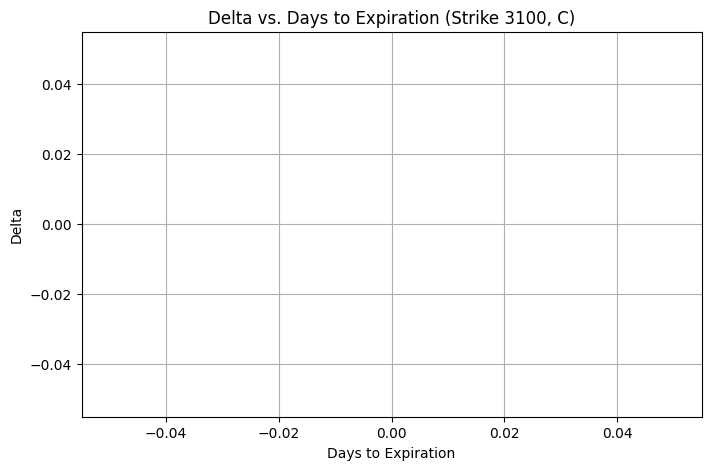

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

file_name = r"C:\TAMID\OptionsData\IVYOPPRCD_199601.pkl"
df = pd.read_pickle(file_name)
print("read df")


STRIKE = 400
DATE = pd.Timestamp("1996-01-04")
option_type = 'C'

filtered = df.loc[(df.index == DATE) & (df['CallPut'] == option_type) & (df['Strike'] == STRIKE)].copy()
for col in ['ImpliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega']:
    filtered = filtered[filtered[col] != -99.99]

filtered = filtered[filtered["Strike"] == STRIKE]

filtered = filtered.copy()
filtered["Date"] = filtered.index

metrics = {
    'ImpliedVolatility': 'Implied Volatility',
    'Delta': 'Delta',
    'Gamma': 'Gamma',
    'Theta': 'Theta',
    'Vega': 'Vega'
}

for col, title in metrics.items():
    plt.figure(figsize=(8, 5))
    plt.scatter(filtered['DaysToExpiration'], filtered[col], color='blue', alpha = 0.7)
    plt.title(f"{title} vs. Days to Expiration\n{DATE.date()}, Strike = {STRIKE}, (ATM {option_type} options)")
    plt.xlabel("Days to Expiration")
    plt.ylabel(title)
    plt.grid(True)
    plt.show()

In [ ]:
import pandas as pd
file_name = r"C:\TAMID\OptionsData\IVYOPPRCD_199601.pkl"
df = pd.read_pickle(file_name)
print(df.iloc[45])